# 2.155/6 Regression Demo: Predicting Aerodynamic Drag on Cyclist

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>


In this demo, we will be predicting drag force on a cyclist using regression models. We are given a dataset of 4000 samples each consisting of 11 predictive parameters (5 key dimensions of the bicycle and 6 dimensions of the rider) and a drag force target. We are asked to predict the drag force in Newtwons experienced by the cyclist in a relative headwind of 10 m/s (22.4 mph). Drag values were collected using Computational Fluid Dynamics simulations on a simple cyclist CAD model.


<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Regression/Riderdims.png" height="300px">
<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Regression/interfacelocations.png" height="300px">

<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Regression/Rideronbike.png" height="400px">
<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Regression/vel.png" height="400px">

In the previous demo, we learned how to use several of Scikit-learn's classification algorithms. Today, we will be using Scikit-learns's regression algorithms, which are equally intuitive.

In [1]:
#Import Data processing packages
import pandas as pd
import numpy as np

#Import Data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

#Import relevant scikit-learn packages
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

### Load and Examine Data

Let's Load the data from Github

In [2]:
url='https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Regression/4kconfigs.csv'
x = pd.read_csv(url, index_col=0)
url='https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Regression/targetdf.csv'
y = pd.read_csv(url, index_col=0)

Print the data:

In [3]:
display(x)
display(y)

SaddleY@Mainsketch  UpperLeg@Mainsketch  HandleX@Mainsketch  \
Config_0000            0.732300             0.408735            0.480960   
Config_0001            0.569000             0.378941            0.479903   
Config_0002            0.328400             0.423010            0.408428   
Config_0003            0.719000             0.373837            0.505000   
Config_0004            0.573000             0.434524            0.494903   
...                         ...                  ...                 ...   
Config_3995            0.673910             0.411508            0.418922   
Config_3996            0.589458             0.390641            0.491237   
Config_3997            0.632694             0.357847            0.456292   
Config_3998            0.537846             0.427543            0.372896   
Config_3999            0.504094             0.348451            0.508970   

             HandleY@Mainsketch  Arm@Mainsketch  SaddleX+.2@Mainsketch  \
Config_0000            0.637631        0.613393               0.414200   
Config_0001            0.394078        0.677262               0.390000   
Config_0002            0.597882        0.625848               0.321000   
Config_0003            0.689000        0.642506               0.423000   
Config_0004            0.333078        0.605950               0.395000   
...                         ...             ...                    ...   
Config_3995            0.367827        0.623026               0.384571   
Config_3996            0.512576        0.645401               0.331450   
Config_3997            0.616549        0.609955               0.257561   
Config_3998            0.549017        0.634352               0.450768   
Config_3999            0.491403        0.616844               0.465386   

             CrankLength@Mainsketch  LowerLeg@Mainsketch  \
Config_0000                0.175000             0.530560   
Config_0001                0.165000             0.520241   
Config_0002                0.175000             0.477640   
Config_0003                0.175000             0.555489   
Config_0004                0.170000             0.515562   
...                             ...                  ...   
Config_3995                0.169155             0.467710   
Config_3996                0.177083             0.497254   
Config_3997                0.182054             0.485833   
Config_3998                0.173000             0.556770   
Config_3999                0.185406             0.502160   

             TorsoLength@Mainsketch  Neckandhead@Mainsketch  \
Config_0000                0.544560                0.291510   
Config_0001                0.491640                0.328007   
Config_0002                0.534241                0.298627   
Config_0003                0.499273                0.274318   
Config_0004                0.550727                0.314776   
...                             ...                     ...   
Config_3995                0.532860                0.302132   
Config_3996                0.555917                0.315087   
Config_3997                0.503746                0.275182   
Config_3998                0.585688                0.295534   
Config_3999                0.497250                0.328549   

             TorsoWidth@Widthdef  
Config_0000             0.362584  
Config_0001             0.330804  
Config_0002             0.377811  
Config_0003             0.356641  
Config_0004             0.291908  
...                          ...  
Config_3995             0.349978  
Config_3996             0.375638  
Config_3997             0.339835  
Config_3998             0.361142  
Config_3999             0.355340  

[4000 rows x 11 columns]

1
0     21.443325
1     18.486205
2     14.954493
3     20.913928
4     15.118547
...         ...
3995  19.470369
3996  21.665211
3997  21.468893
3998  21.059600
3999  16.105189

[4000 rows x 1 columns]

Let's make a nice pairplot of 4 of our 11 input variables color coded by corresponding drag values. Unfortunately, seaborn's pairplot doesn't support continuous labels, so we need to go under the hood a little bit and use pairgrid. This will take around 10 seconds to run.

/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xcomb["drag"]=y.values #Add column called drag to dataframe
/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.axes[0, 0].legend(loc="center left") #Put legend on center left of upper left plot


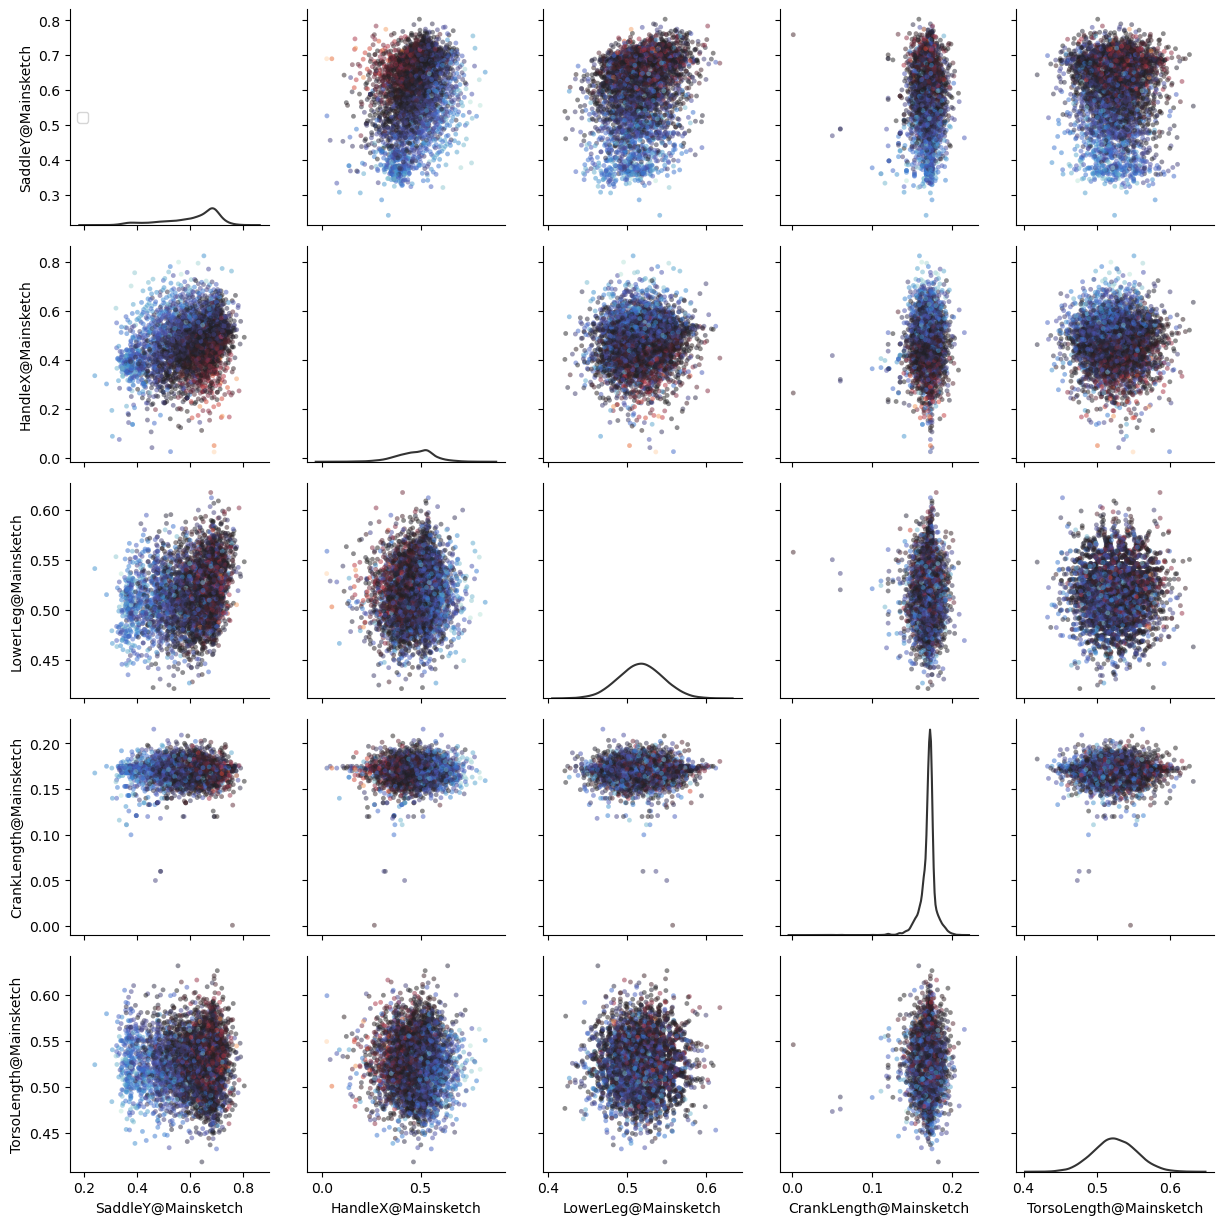

In [4]:
def plot_pairplot(x, y):
  #Take a subset (otherwise plotting takes forever)
  xcomb=x[["SaddleY@Mainsketch", "HandleX@Mainsketch", "LowerLeg@Mainsketch", "CrankLength@Mainsketch", "TorsoLength@Mainsketch"]]
  origcols=xcomb.columns
  xcomb["drag"]=y.values #Add column called drag to dataframe
  g = sns.PairGrid(xcomb, vars=origcols)
  g.map_diag(sns.kdeplot, color=".2") #set diag color to a shade of gray
  g.map_offdiag(sns.scatterplot, hue=xcomb["drag"], s=12, linewidth=0, palette="icefire", alpha = 0.5) #color code off-diagonals using "drag"
  g.axes[0, 0].legend(loc="center left") #Put legend on center left of upper left plot
plot_pairplot(x, y) #Plot the data

### Min-Max Scaling

Let's preprocess the data. The first thing to think about is scaling. If we have many outliers or heavily non-gaussian distributions, we would look to more advanced scalers, such as scikit-learn's robust scaler. As we see above. we don't have significant numbers of outliers and our distribution is pretty close to normal. As such, we first try the simplest scaler out there: min-max scaling.


In [5]:
from sklearn.preprocessing import MinMaxScaler

x_unscaled=x.copy(deep="true")
scaler = MinMaxScaler() #initialize scaler
x_minmax = scaler.fit_transform(x) #fit and transform
x_minmax = pd.DataFrame(data=x_minmax, columns=x.columns, index=x.index )


Let's see what this did to our distributions. Let's repeat our pairplot using our scaled data. You should see that each feature-wise distribution is now confined to 0-1.

/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xcomb["drag"]=y.values #Add column called drag to dataframe
/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.axes[0, 0].legend(loc="center left") #Put legend on center left of upper left plot


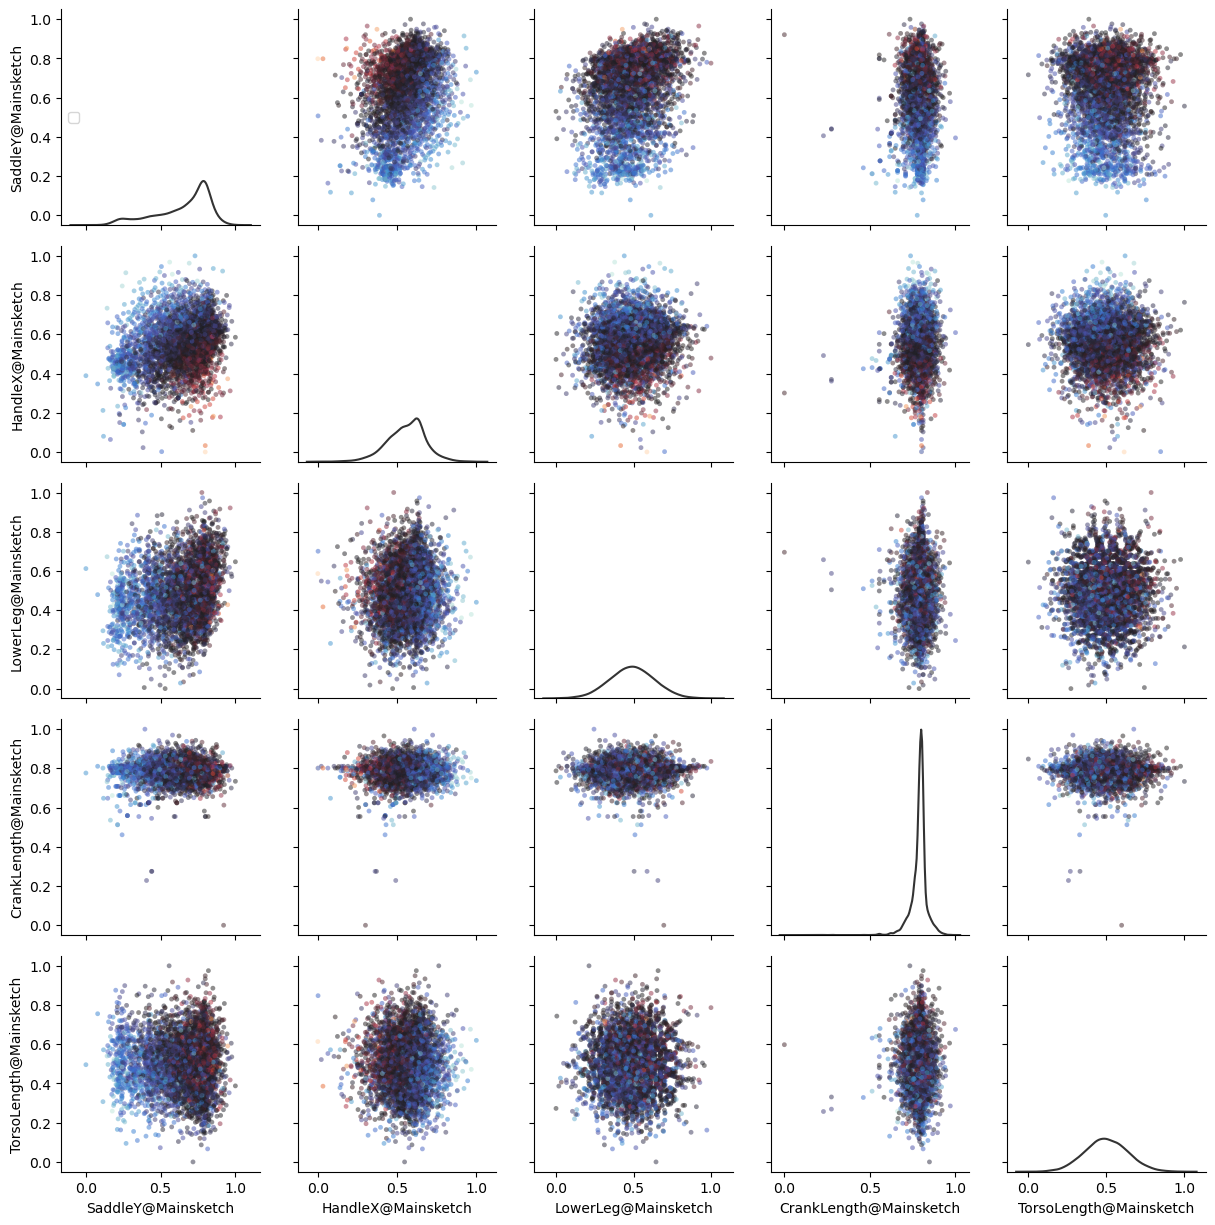

In [6]:
plot_pairplot(x_minmax, y)

### Standard Scaling

Next, we use an 'standard' mean/variance scaler. This scaler normalizes each feature in the dataset to have a mean of 0 and a variance of 1 across all the datapoints.

In [7]:
from sklearn.preprocessing import StandardScaler

x_unscaled=x.copy(deep="true")
scaler = StandardScaler()
x_meanvar = scaler.fit_transform(x)
x_meanvar = pd.DataFrame(data=x_meanvar, columns=x.columns, index=x.index )

Let's see what this did to our distributions. Let's repeat our pairplot using our scaled data. You should see that our distributions are now centered around zero.

/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xcomb["drag"]=y.values #Add column called drag to dataframe
/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.axes[0, 0].legend(loc="center left") #Put legend on center left of upper left plot


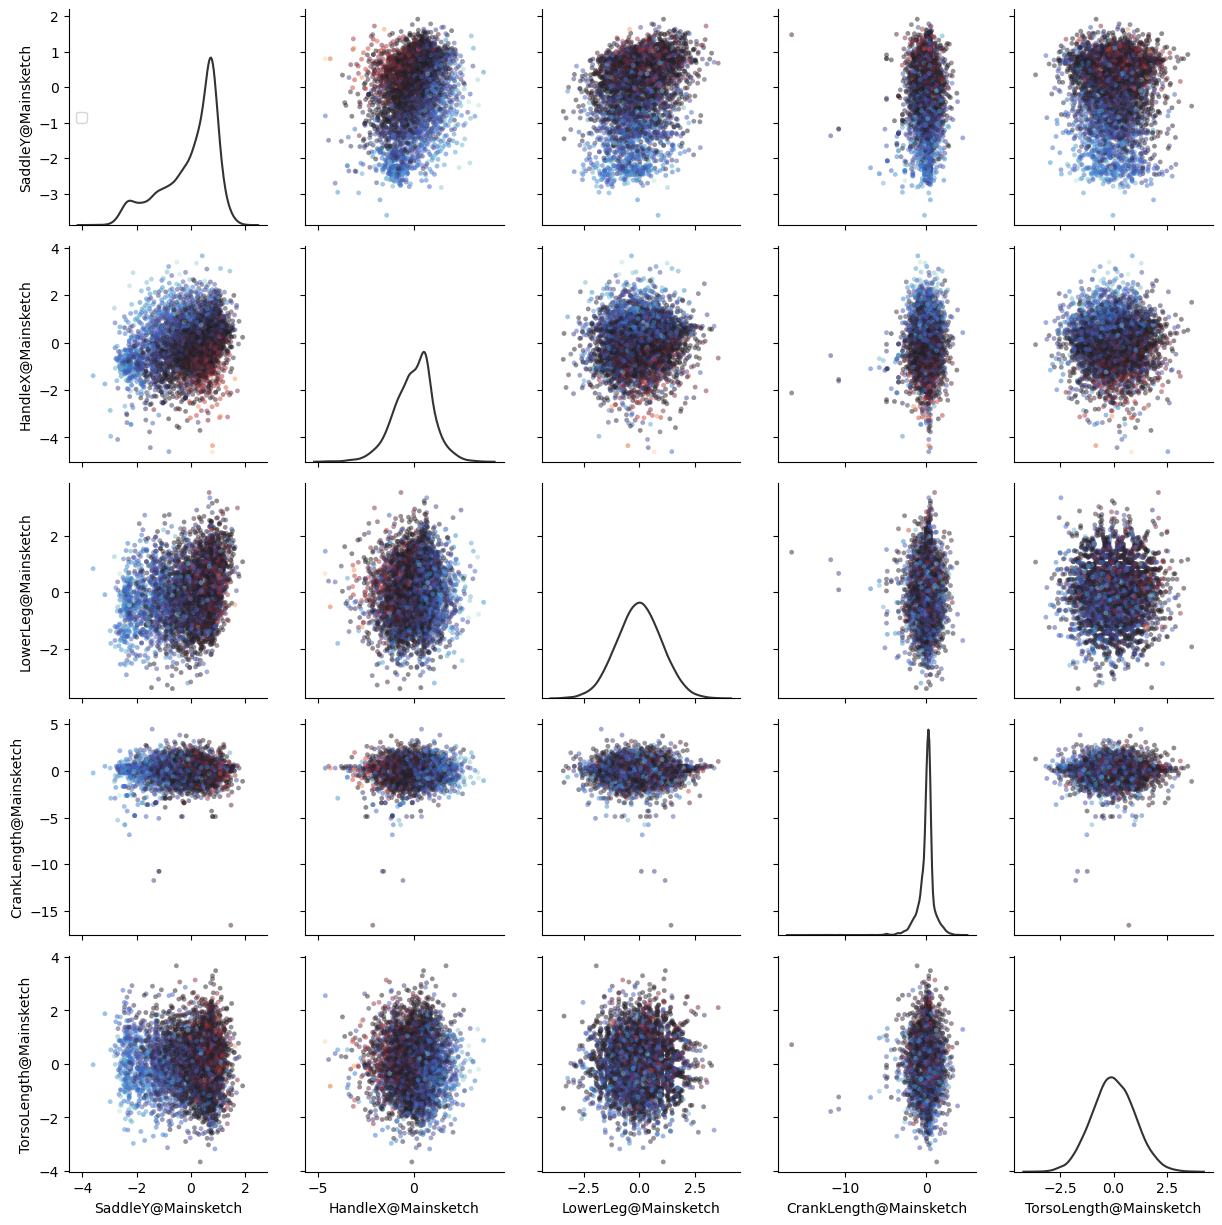

In [8]:
plot_pairplot(x_meanvar, y)

### Nonlinear Transformations

As an alternative to scaling, we can also try nonlinear transformations to our data. Let's try a mapping to a uniform distribution using a quantile transformer. Here, we effectively adjust each data point's variable to its quantile value. This is an effective tool when we are working with a model that effectively assumes certain standard properties about a distribution.

In [9]:
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(random_state=0)
x_quant = quantile_transformer.fit_transform(x)
x_quant = pd.DataFrame(data=x_quant, columns=x.columns, index=x.index )

Let's see what this did to our distributions again. We can see that this quantile scaling has exposed some discontinuities in certain parameters in the dataset. We notice that many of the crank length values fall into discrete values. Why? Well many bikes use off-the-shelf cranks which may have fixed whole-number crank lengths.

/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xcomb["drag"]=y.values #Add column called drag to dataframe
/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.axes[0, 0].legend(loc="center left") #Put legend on center left of upper left plot


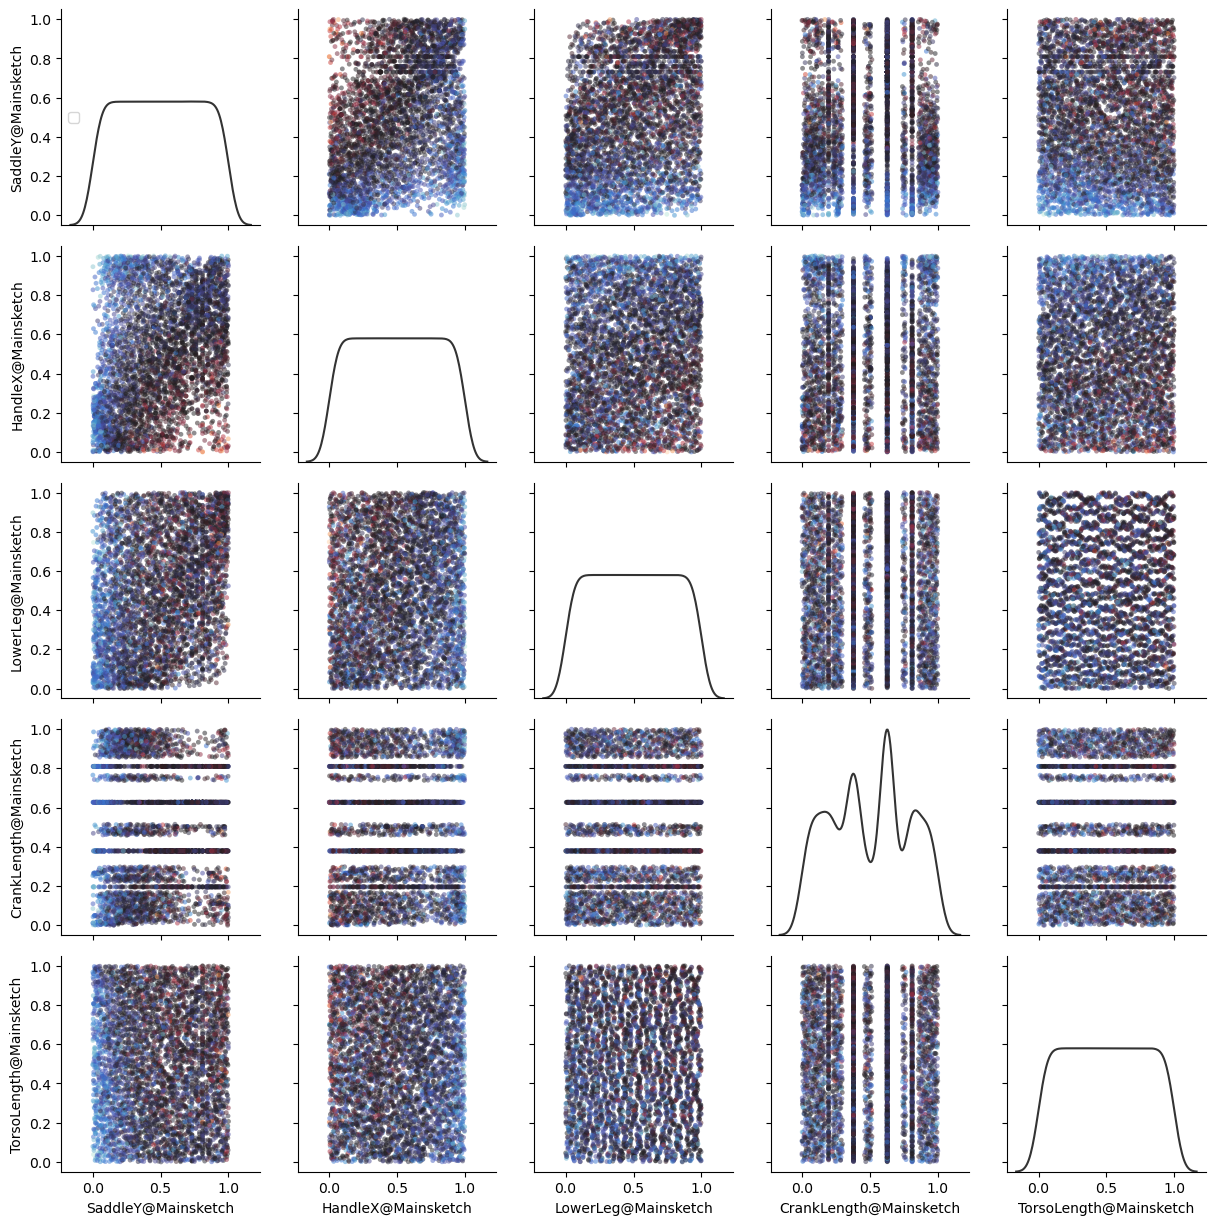

In [10]:
plot_pairplot(x_quant, y)

### Normalization

With normalization, we scale individual samples to have a unit norm. Note that unlike many other normalization techniques where data is samples according to the distribution of **features**, in this technique, **samples** are normalized independently of one another.  To verify, we see that each feature value is strictly bounded between -1 and 1

In [11]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
x_normalized = normalizer.fit_transform(x)
x_normalized = pd.DataFrame(data=x_normalized, columns=x.columns, index=x.index )

/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xcomb["drag"]=y.values #Add column called drag to dataframe
/var/folders/28/9nt7509j5793vtncq256zgwr0000gn/T/ipykernel_51678/4104453615.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.axes[0, 0].legend(loc="center left") #Put legend on center left of upper left plot


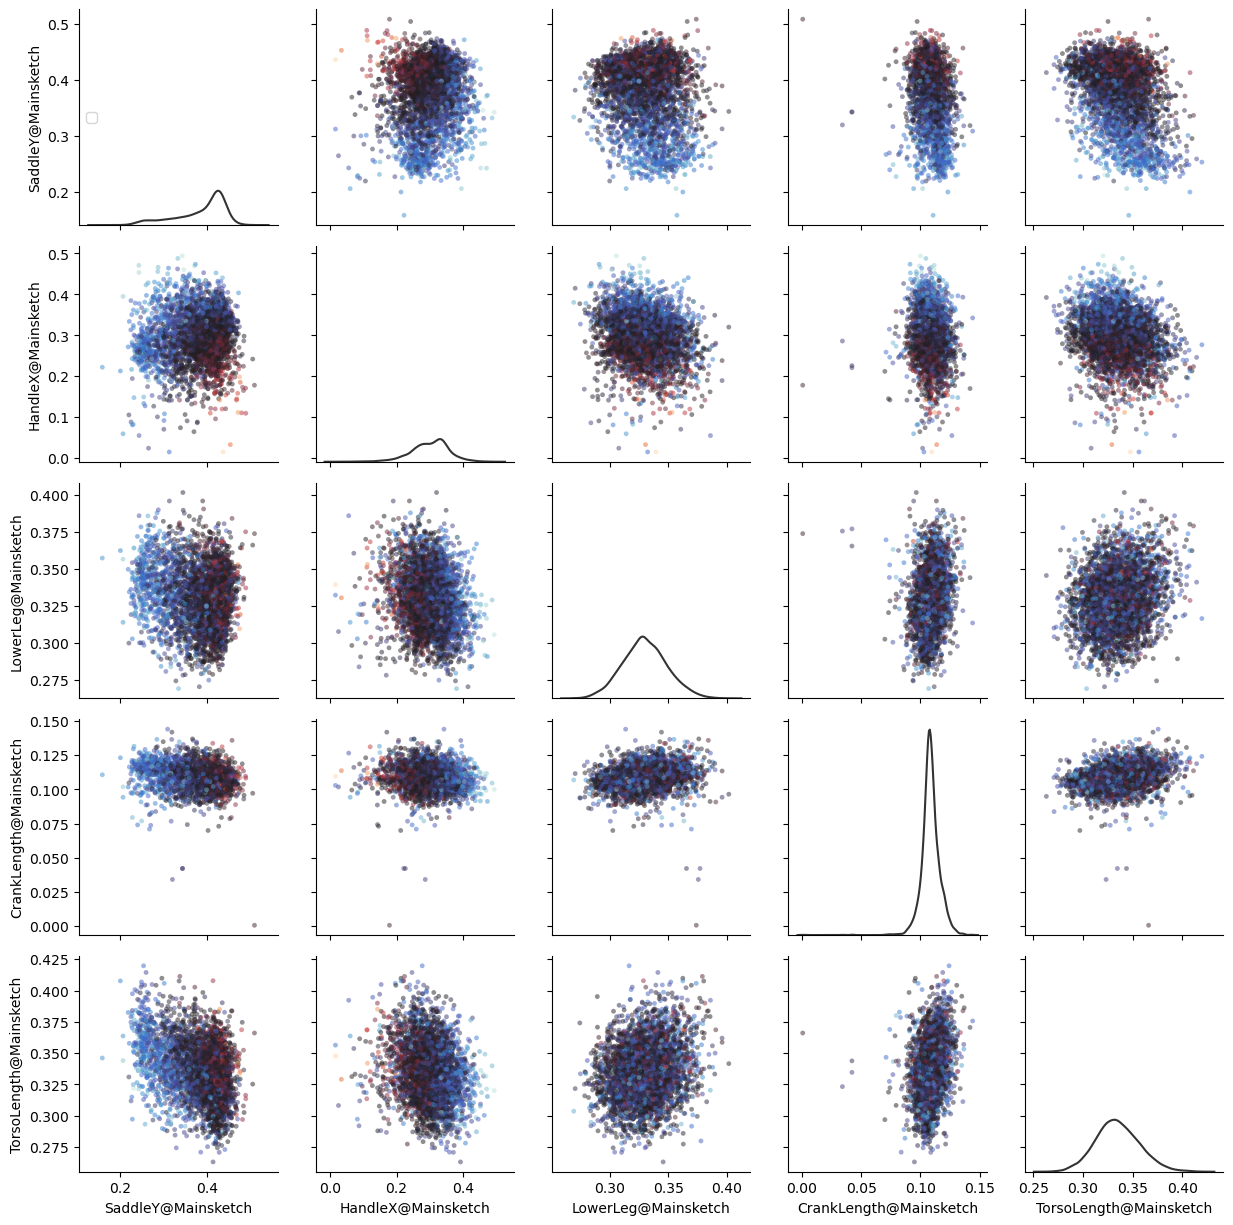

In [12]:
plot_pairplot(x_normalized, y)

### Training Regression Models

Let's use our data from the simple scalar to train some models. We will split into train+val & test, then use 4-fold crossvalidation.

In [13]:
x_sc_df=pd.DataFrame(x_meanvar, columns=x.columns, index=x.index)
Xtv, Xtest, Ytv, Ytest = train_test_split(x_sc_df, y, train_size=3200, shuffle=True, random_state=2997)

def setup_kfold(Xtv, Ytv, num_splits=4):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=2997)
    kf.get_n_splits(Xtv,Ytv)
    #Create four lists which will hold x/y train/val data for every split
    Xtrain=[]
    Xval=[]
    Ytrain=[]
    Yval=[]
    for train_index, test_index in kf.split(Xtv): #loop over splits
        Xtrainfold, Xvalfold = Xtv.iloc[train_index], Xtv.iloc[test_index]
        Ytrainfold, Yvalfold = Ytv.iloc[train_index], Ytv.iloc[test_index]
        Ytrainfold = np.squeeze(Ytrainfold) #Convert Y datasets to row vectors to prevent sklearn from complaining
        Yvalfold = np.squeeze(Yvalfold) #Same

        #Append data to lists
        Xtrain.append(Xtrainfold)
        Xval.append(Xvalfold)
        Ytrain.append(Ytrainfold)
        Yval.append(Yvalfold)
    return Xtrain, Ytrain, Xval, Yval

num_splits = 4
Xtrain, Ytrain, Xval, Yval = setup_kfold(Xtv, Ytv, num_splits) #Xtrain, Ytrain, etc are all lists of data splits


#take a look at the first items in Xtrain and Xval. Each dataset in Xtrain has 3x as many entriex as Xval (since 4 splits)
print("Train Set 0:")
display(Xtrain[0])
print("Val Set 0:")
display(Xval[0])


Train Set 0:


SaddleY@Mainsketch  UpperLeg@Mainsketch  HandleX@Mainsketch  \
Config_0642            0.612090             0.431435            0.810377   
Config_1520           -0.563981             0.985283           -0.105936   
Config_3814            0.477735             0.094628           -1.122933   
Config_0897            0.543486             0.186373           -0.269909   
Config_1593           -0.338567            -0.729062           -0.846633   
...                         ...                  ...                 ...   
Config_0342            0.651292             0.233800            0.959296   
Config_1315            0.915908             0.007102            1.290968   
Config_1897            0.675891            -0.369687           -0.263861   
Config_3955            0.717563             0.055129           -0.798460   
Config_3148            0.450223             1.415061           -1.257046   

             HandleY@Mainsketch  Arm@Mainsketch  SaddleX+.2@Mainsketch  \
Config_0642           -0.502816        0.480848               1.116526   
Config_1520            0.664648       -0.175653              -0.249980   
Config_3814           -0.861966       -1.885784               0.734566   
Config_0897            1.400047        1.298022              -0.512050   
Config_1593            0.687024       -0.085809              -0.381015   
...                         ...             ...                    ...   
Config_0342            0.273151       -0.616227               0.929334   
Config_1315            1.178075       -0.606619               0.742141   
Config_1897            0.373229        0.924525               0.619904   
Config_3955            0.784491       -0.186018               0.945553   
Config_3148           -0.731752        1.578961              -0.291939   

             CrankLength@Mainsketch  LowerLeg@Mainsketch  \
Config_0642               -0.499690             0.764768   
Config_1520                0.476600            -0.236558   
Config_3814               -1.105708            -0.164538   
Config_0897               -0.987835            -0.253533   
Config_1593                0.281342            -1.367302   
...                             ...                  ...   
Config_0342                0.281342             0.073941   
Config_1315                0.281342             1.716812   
Config_1897               -0.011545             0.062796   
Config_3955               -1.614184             0.133250   
Config_3148               -0.741724            -1.949901   

             TorsoLength@Mainsketch  Neckandhead@Mainsketch  \
Config_0642                1.565006               -2.090216   
Config_1520               -0.039721                1.075727   
Config_3814               -0.213540               -0.022936   
Config_0897               -0.656496               -1.271317   
Config_1593               -0.308895               -1.005766   
...                             ...                     ...   
Config_0342               -1.447211               -0.439782   
Config_1315               -0.892754               -1.009809   
Config_1897               -1.205872               -0.425649   
Config_3955                0.377619               -0.906253   
Config_3148               -0.498165                0.039195   

             TorsoWidth@Widthdef  
Config_0642            -1.978276  
Config_1520            -0.399108  
Config_3814            -0.261582  
Config_0897            -0.627283  
Config_1593            -1.021878  
...                          ...  
Config_0342             0.488047  
Config_1315            -1.574653  
Config_1897             1.467323  
Config_3955            -0.843830  
Config_3148            -0.794924  

[2400 rows x 11 columns]

Val Set 0:


SaddleY@Mainsketch  UpperLeg@Mainsketch  HandleX@Mainsketch  \
Config_0754            0.798301            -0.863621           -0.260515   
Config_0280            0.798301             0.523774            1.006207   
Config_1557            0.896307             0.723923            0.480637   
Config_0563            0.543486             1.477403            0.150868   
Config_3893           -0.603899            -0.309743           -1.479284   
...                         ...                  ...                 ...   
Config_2136            0.768899            -0.844758            0.160681   
Config_3747            0.212817            -0.023791            0.515834   
Config_3152           -0.675812            -1.441039            1.074390   
Config_1602            1.082518             2.024169            0.747737   
Config_0773            0.700295             0.206368            1.553089   

             HandleY@Mainsketch  Arm@Mainsketch  SaddleX+.2@Mainsketch  \
Config_0754            0.818858       -0.715601               0.049528   
Config_0280           -0.340032        0.284326               0.049528   
Config_1557           -0.224375        0.793803               0.218002   
Config_0563           -0.282204       -0.786894              -0.193822   
Config_3893           -0.758437        0.714349              -0.619417   
...                         ...             ...                    ...   
Config_2136           -0.900844        0.468004              -0.268699   
Config_3747           -0.392041       -0.258203               1.959542   
Config_3152           -1.666457        1.175744               1.918539   
Config_1602            0.852698        0.013347               0.629825   
Config_0773            2.416102       -0.997119               0.648545   

             CrankLength@Mainsketch  LowerLeg@Mainsketch  \
Config_0754                0.281342             1.447443   
Config_0280                0.281342            -1.323089   
Config_1557               -0.011545            -0.956809   
Config_0563               -0.011545            -2.122078   
Config_3893               -0.396837            -0.469745   
...                             ...                  ...   
Config_2136               -0.011545             0.251635   
Config_3747               -2.246846            -0.032627   
Config_3152                0.646075            -0.269571   
Config_1602               -0.011545            -0.347453   
Config_0773                0.281342            -0.936756   

             TorsoLength@Mainsketch  Neckandhead@Mainsketch  \
Config_0754                0.085740               -0.471048   
Config_0280                0.059996               -0.141734   
Config_1557               -0.098588                0.211529   
Config_0563               -0.194482               -0.086057   
Config_3893                0.838324               -1.368893   
...                             ...                     ...   
Config_2136               -1.157067                0.680710   
Config_3747               -0.203533               -0.439445   
Config_3152                2.594408               -1.415051   
Config_1602                0.927953                0.344756   
Config_0773                2.194804                2.498515   

             TorsoWidth@Widthdef  
Config_0754             1.136384  
Config_0280             0.188607  
Config_1557            -0.552346  
Config_0563             1.706020  
Config_3893            -0.298332  
...                          ...  
Config_2136            -1.057283  
Config_3747            -0.171788  
Config_3152            -1.980510  
Config_1602             0.732135  
Config_0773            -0.531825  

[800 rows x 11 columns]

Let's try some regression methods. We will test out linear regression, a simple decision tree, a Gradient-Boosting Decision Trees regressor, and a deep classifier (neural network). Some of these methods are simply the counterparts of their classification relatives, which should hopefully be familiar!

In [14]:
def fit_model_calc_score(model, modelname, X_train_splits, Y_train_splits, X_val_splits, Y_val_splits):
  #Function to fit model and calculate scores.
  #Takes in model, model name (for use in print statement only), and data splits

  total_score = 0 #We will accumulate the total score over splits
  for split in range(num_splits): #Loop over splits
      model.fit(X_train_splits[split], Y_train_splits[split]) #Fit model on split
      total_score += model.score(X_val_splits[split], Y_val_splits[split]) #Evaluate model on split and add to total score
  score = total_score / num_splits #average scores
  print(f"{modelname} mean R2: {100*score:.2f} %") #print score

In [15]:
LR = LinearRegression() #Initialize linear regression model
fit_model_calc_score(LR, "LR", Xtrain, Ytrain, Xval, Yval)

LR mean R2: 80.95 %


In [16]:
DT = DecisionTreeRegressor(max_depth=8)
fit_model_calc_score(DT, "DT", Xtrain, Ytrain, Xval, Yval)


DT mean R2: 66.78 %


In [17]:
GB = GradientBoostingRegressor(n_estimators=200, max_depth=5)
fit_model_calc_score(GB, "GB", Xtrain, Ytrain, Xval, Yval)

GB mean R2: 91.46 %


In [18]:
NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)
fit_model_calc_score(NN, "NN", Xtrain, Ytrain, Xval, Yval)

NN mean R2: 94.47 %


### Comparing Performance of Preprocessing Methods

It seems like the Neural Network is the strongest regressor. Let's compare how the neural net and linear regression models perform on data that underwent different preprocessing. First up is no scaling. Since our standard scalar was a linear scalar, linear regression should perform identially to our standard scalar case. In practice, we see that the neural net also performs similarly. You can also test min-max scaling. You should see a fairly similar result.

In [19]:
x_df_unscaled=pd.DataFrame(x_unscaled, columns=x.columns, index=x.index)
Xtv_unscaled, Xtest_unscaled, Ytv_unscaled, Ytest_unscaled = train_test_split(x_df_unscaled, y, train_size=3200, shuffle=True, random_state=2997)
Xtrain_unscaled, Ytrain_unscaled, Xval_unscaled, Yval_unscaled = setup_kfold(Xtv_unscaled, Ytv_unscaled, num_splits)

Linear = LinearRegression()
fit_model_calc_score(LR, "LR (unscaled)", Xtrain_unscaled, Ytrain_unscaled, Xval_unscaled, Yval_unscaled)

NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)
fit_model_calc_score(NN, "NN (unscaled)", Xtrain_unscaled, Ytrain_unscaled, Xval_unscaled, Yval_unscaled)

LR (unscaled) mean R2: 80.95 %
NN (unscaled) mean R2: 93.93 %


Next up is our quantile transformation. We see that both the  linear regression model's performance drops. The neural network sometimes sees lower performance as well.

In [20]:
x_df_quant=pd.DataFrame(x_quant, columns=x.columns, index=x.index)
Xtv_quant, Xtest_quant, Ytv_quant, Ytest_quant = train_test_split(x_df_quant, y, train_size=3200, shuffle=True, random_state=2997)
Xtrain_quant, Ytrain_quant, Xval_quant, Yval_quant = setup_kfold(Xtv_quant, Ytv_quant, num_splits)

Linear = LinearRegression()
fit_model_calc_score(LR, "LR (quantile transform)", Xtrain_quant, Ytrain_quant, Xval_quant, Yval_quant)

NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)
fit_model_calc_score(NN, "NN (quantile transform)", Xtrain_quant, Ytrain_quant, Xval_quant, Yval_quant)

LR (quantile transform) mean R2: 67.41 %
NN (quantile transform) mean R2: 91.37 %


Finally, we test normalization. Normalization slightly damages linear regression performance, and signficantly reduces neural network performance.

In [21]:
x_df_normalized=pd.DataFrame(x_normalized, columns=x.columns, index=x.index)
Xtv_norm, Xtest_norm, Ytv_norm, Ytest_norm = train_test_split(x_df_normalized, y, train_size=3200, shuffle=True, random_state=2997)

Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm = setup_kfold(Xtv_norm, Ytv_norm, num_splits)

Linear = LinearRegression()
fit_model_calc_score(LR, "LR (normalized)", Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm)

NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)
fit_model_calc_score(NN, "NN (normalized)", Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm)

LR (normalized) mean R2: 78.03 %
NN (normalized) mean R2: 87.07 %


We see that for this problem, many of the preprocessing methods end up distorting the data to the detriment of the model.

### Feature Engineering
Let's try creating some polynomial features and seeing it this improves performance. We select degree 2 polynomials and we can see that our 11 features get expanded into 78 polynomial features.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
x_poly = poly.fit_transform(x_meanvar)

x_poly_df = pd.DataFrame(x_poly)
Xtv_poly, Xtest_poly, Ytv_poly, Ytest_poly = train_test_split(x_poly_df, y, train_size=3200, shuffle=True, random_state=2997)

Xtrain_poly, Ytrain_poly, Xval_poly, Yval_poly = setup_kfold(Xtv_poly, Ytv_norm, num_splits)

print(f"Shape of Polynomial features: {np.shape(x_poly)}")

Shape of Polynomial features: (4000, 78)


Ok, lets retrain our linear regression and neural network models. There is typically some variability in scores, but our neural network regressor often performs worse, due to overfitting. Overfitting is common when we have very high dimensional data and not enough training samples. The regression peformance of linear regression, on the other hand, should have skyrocketed. Linear regression on the augmented dataset should now yield accuracy that rivals (or even surpasses) the neural network! Including polynomial features can drastically boost supervised learning performance, especially in more 'lightweight' models like linear regression.

In [23]:
Linear = LinearRegression()
fit_model_calc_score(LR, "LR (polynomial features)", Xtrain_poly, Ytrain_poly, Xval_poly, Yval_poly)

NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)
fit_model_calc_score(NN, "NN (polynomial features)", Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm)

LR (polynomial features) mean R2: 94.03 %
NN (polynomial features) mean R2: 86.80 %


### Feature Engineering with Domain Knowledge
Perhaps we can improve the performance with some "domain knowledge." Let's calculate some additional quantities deterministically. We will calculate the height of the rider's torso, the distance from the top of the head to the ground, the width of the rider's thigh, and estimate the full frontal surface area of the legs as well as the entire torso. Don't worry about the math here; it's all just simple geometry.

In [24]:
#Calculate key dimensions of interest
additionaldata=np.zeros((len(x_unscaled.values[:,1]),5))
for i in range(len(x_unscaled.values[:,1])):
    p = x_unscaled.values[i,:]
    arm = p[4]
    back = p[8]
    head = p[9]
    ul = p[1]
    ll = p[7]
    Lsh = np.sqrt((p[5]-0.2+p[2])**2+(p[0]-p[3])**2) #distance from saddle to handlebar
    Lspl = np.sqrt((p[5]-0.2)**2+p[0]**2)+p[6] #distance from saddle to pedals in farthest pos
    Lsps = np.sqrt((p[5]-0.2)**2+p[0]**2)-p[6] #distance from saddle to pedals in closest pos
    Tsh = np.arctan((p[3]-p[0])/(p[5]-0.2+p[2])) #angle from saddle to handlebar in degrees
    Tsp2 = np.arctan(-(p[0]+p[6])/(p[5]-0.2)) #angle from saddle to lower pedal in degrees
    Tssh = np.arccos((back**2+Lsh**2-arm**2)/(2*back*Lsh)) #angle from shoulders to saddle to handle 15
    Tksp = np.arccos((ul**2+Lsps**2-ll**2)/(2*ul*Lsps)) #angle from knee to saddle to closest pedal pos
    Tskp = np.arccos((ul**2+ll**2-Lsps**2)/(2*ul*ll)) #angle from saddle to knee to closest pedal pos
    Tksp2 = np.arccos((ul**2+Lspl**2-ll**2)/(2*ul*Lspl)) #angle from knee to saddle to farthest pedal pos
    backverticalheight = back*np.sin(Tsh+Tssh)
    shoulderheight = backverticalheight+p[0]
    headheight = (back+head)*np.sin(Tsh+Tssh)
    armheight = shoulderheight-p[2]
    thighwidth = (p[10]/2-.16)/2
    lowerkneeheight = ul*np.sin(Tksp2+Tsp2)
    if lowerkneeheight<p[0]:
        legarea = (p[0]-lowerkneeheight)*(thighwidth-.12)+2*p[0]*.12
    else:
        legarea = 2*p[0]*.12
    frontalsa = armheight*.1+shoulderheight*p[10]+np.pi/16+.1*p[10]*np.cos(Tsh+Tssh)
    additionaldata[i,:] = [backverticalheight, headheight, thighwidth, legarea, frontalsa]
#assemble dataframe of augmented data
additionaldata = pd.DataFrame(additionaldata, columns=["Back Vertical Height","Head Height","Thigh Width","legarea","Frontal Surface Area"],index=x.index)
print("Calculated parameters:")
display(additionaldata)
x_augmented = pd.concat([x_unscaled,additionaldata], axis=1)
print("Full augmented data:")
display(x_augmented)

Calculated parameters:


Back Vertical Height  Head Height  Thigh Width   legarea  \
Config_0000              0.414526     0.636426     0.010646  0.052868   
Config_0001              0.391064     0.651970     0.002701  0.042648   
Config_0002              0.532866     0.830725     0.014453  0.031002   
Config_0003              0.420217     0.651098     0.009160  0.053464   
Config_0004              0.316742     0.497780    -0.007023  0.032017   
...                           ...          ...          ...       ...   
Config_3995              0.295948     0.463751     0.007494  0.043046   
Config_3996              0.475229     0.744582     0.013910  0.048188   
Config_3997              0.478616     0.740070     0.004959  0.040579   
Config_3998              0.527317     0.793397     0.010286  0.050120   
Config_3999              0.390650     0.648765     0.008835  0.042414   

             Frontal Surface Area  
Config_0000              0.702270  
Config_0001              0.582007  
Config_0002              0.564321  
Config_0003              0.685321  
Config_0004              0.519436  
...                           ...  
Config_3995              0.619975  
Config_3996              0.673122  
Config_3997              0.650112  
Config_3998              0.665968  
Config_3999              0.574851  

[4000 rows x 5 columns]

Full augmented data:


SaddleY@Mainsketch  UpperLeg@Mainsketch  HandleX@Mainsketch  \
Config_0000            0.732300             0.408735            0.480960   
Config_0001            0.569000             0.378941            0.479903   
Config_0002            0.328400             0.423010            0.408428   
Config_0003            0.719000             0.373837            0.505000   
Config_0004            0.573000             0.434524            0.494903   
...                         ...                  ...                 ...   
Config_3995            0.673910             0.411508            0.418922   
Config_3996            0.589458             0.390641            0.491237   
Config_3997            0.632694             0.357847            0.456292   
Config_3998            0.537846             0.427543            0.372896   
Config_3999            0.504094             0.348451            0.508970   

             HandleY@Mainsketch  Arm@Mainsketch  SaddleX+.2@Mainsketch  \
Config_0000            0.637631        0.613393               0.414200   
Config_0001            0.394078        0.677262               0.390000   
Config_0002            0.597882        0.625848               0.321000   
Config_0003            0.689000        0.642506               0.423000   
Config_0004            0.333078        0.605950               0.395000   
...                         ...             ...                    ...   
Config_3995            0.367827        0.623026               0.384571   
Config_3996            0.512576        0.645401               0.331450   
Config_3997            0.616549        0.609955               0.257561   
Config_3998            0.549017        0.634352               0.450768   
Config_3999            0.491403        0.616844               0.465386   

             CrankLength@Mainsketch  LowerLeg@Mainsketch  \
Config_0000                0.175000             0.530560   
Config_0001                0.165000             0.520241   
Config_0002                0.175000             0.477640   
Config_0003                0.175000             0.555489   
Config_0004                0.170000             0.515562   
...                             ...                  ...   
Config_3995                0.169155             0.467710   
Config_3996                0.177083             0.497254   
Config_3997                0.182054             0.485833   
Config_3998                0.173000             0.556770   
Config_3999                0.185406             0.502160   

             TorsoLength@Mainsketch  Neckandhead@Mainsketch  \
Config_0000                0.544560                0.291510   
Config_0001                0.491640                0.328007   
Config_0002                0.534241                0.298627   
Config_0003                0.499273                0.274318   
Config_0004                0.550727                0.314776   
...                             ...                     ...   
Config_3995                0.532860                0.302132   
Config_3996                0.555917                0.315087   
Config_3997                0.503746                0.275182   
Config_3998                0.585688                0.295534   
Config_3999                0.497250                0.328549   

             TorsoWidth@Widthdef  Back Vertical Height  Head Height  \
Config_0000             0.362584              0.414526     0.636426   
Config_0001             0.330804              0.391064     0.651970   
Config_0002             0.377811              0.532866     0.830725   
Config_0003             0.356641              0.420217     0.651098   
Config_0004             0.291908              0.316742     0.497780   
...                          ...                   ...          ...   
Config_3995             0.349978              0.295948     0.463751   
Config_3996             0.375638              0.475229     0.744582   
Config_3997             0.339835              0.478616     0.740070   
Config_3998            

Great! We've augmented our dataset with 5 deterministically calculated parameters instead of the extra 142 generated from polynomial features. Let's resplit the dataset using the augmented x values.

In [25]:
scaler = StandardScaler()
x_aug_scaled=scaler.fit_transform(x_augmented)
x_augmented=pd.DataFrame(data=x_aug_scaled, columns=x_augmented.columns, index=x_augmented.index )
Xtv_aug, Xtest_aug, Ytv_aug, Ytest_aug = train_test_split(x_augmented, y, train_size=3200, shuffle=True, random_state=2997)
Xtrain_aug, Ytrain_aug, Xval_aug, Yval_aug = setup_kfold(Xtv_aug, Ytv_norm, num_splits)


Let's test out linear regression and a neural network on the augmented data. We hope to see improved classification accuracy after our attempt to impart domain expertise.

In [26]:
Linear = LinearRegression()
fit_model_calc_score(LR, "LR (custom features)", Xtrain_aug, Ytrain_aug, Xval_aug, Yval_aug)

NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)
fit_model_calc_score(NN, "NN (custom features)", Xtrain_aug, Ytrain_aug, Xval_aug, Yval_aug)

LR (custom features) mean R2: 93.75 %
NN (custom features) mean R2: 94.52 %


Selectively imparting domain expertise can drastically improve ML's performance over the baseline, but in this case, it did not add as much performance as systematically chosen polynomial features, at least in linear regression. Can you think of times when polynomial features may not be as successful? In particular, consider data dimensionality. What if our data had more than 11 parameters? What is the risk when we have too many features?

Let's plot some statistics about our linear regression model's predictions on the polynomial feature test set after training on all folds of the train/val data. We plot predictions against our known drag values to confirm. Don't worry about the details here.

R2 Score: 0.9386661814190229
Test set Mean Squared Error: 0.3957594116577638
Test set Mean Absolute Error: 0.4760696162968749


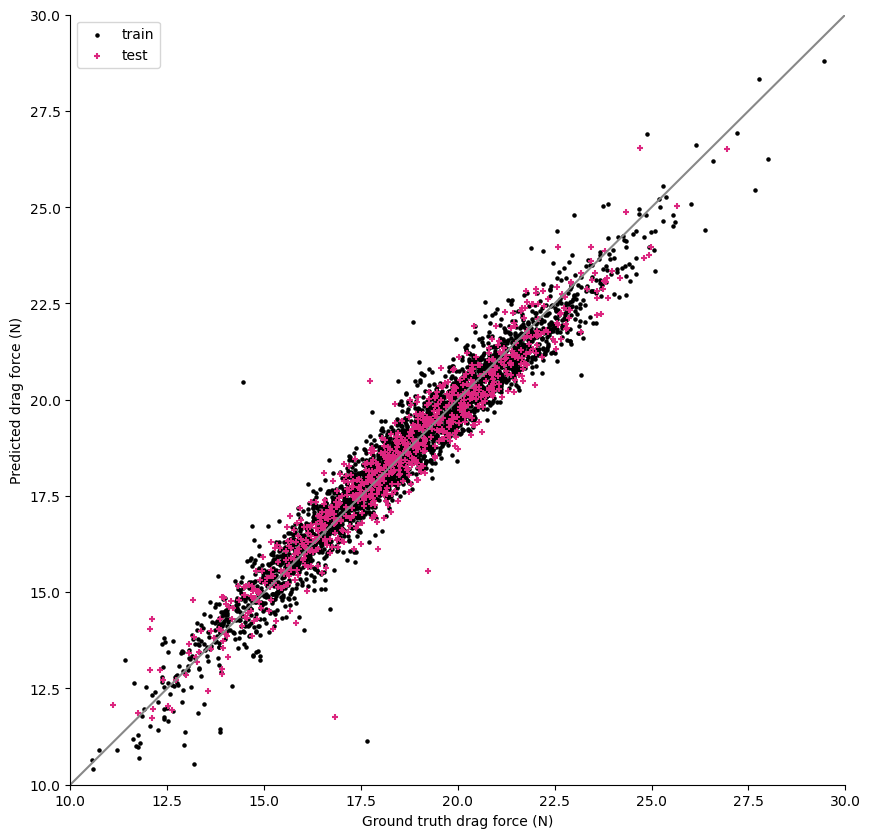

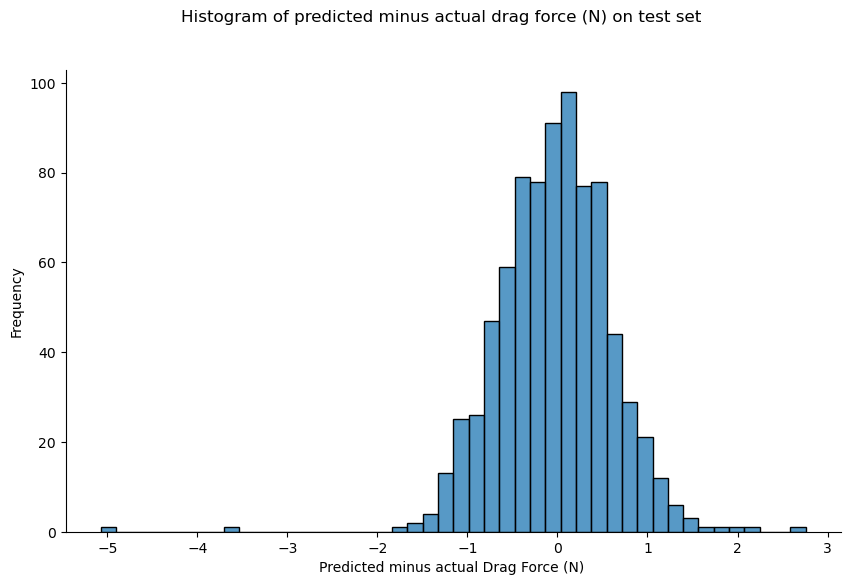

In [27]:
def plot_performance(model, X_train, y_train, X_test, y_test):
    #get predictions for train and test data
    y_test_predict=model.predict(X_test)
    y_train_predict=model.predict(X_train)

    print(f"R2 Score: {model.score(X_test, y_test)}")
    print(f"Test set Mean Squared Error: {mean_squared_error(y_test_predict,y_test)}")
    print(f"Test set Mean Absolute Error: {mean_absolute_error(y_test_predict,y_test)}")

    plotscatter(y_test_predict, y_train_predict, X_train, y_train, X_test, y_test)
    ploterror(y_test_predict, y_train_predict, X_train, y_train, X_test, y_test)

def plotscatter(y_test_predict, y_train_predict, X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(10,10))

    #scatterplots in different colors for train and test data
    plt.scatter(x=y_train, y=y_train_predict, c="#000000", label="train", s=20, marker = ".")
    plt.scatter(x=y_test, y=y_test_predict, c="#DC267F", label="test", s=20, marker = "+")

    #axes labels
    plt.ylabel("Predicted drag force (N)")
    plt.xlabel("Ground truth drag force (N)")
    ax = plt.gca()
    add_identity(ax)
    plt.legend()

    #set ranges manually
    plt.xlim([10, 30])
    plt.ylim([10, 30])

    #get rid of top and right boundaries
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def ploterror(y_test_predict, y_train_predict, X_train, y_train, X_test, y_test):
    #calculate errors
    testdif = np.squeeze(y_test_predict)-np.squeeze(y_test)

    #histogram of errors
    fig = plt.figure(figsize=(10,6))
    sns.histplot(testdif, kde=False);
    plt.xlabel('Predicted minus actual Drag Force (N) ')
    plt.ylabel('Frequency')
    fig.figure.suptitle("Histogram of predicted minus actual drag force (N) on test set")

    #get rid of top and right boundaries
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def add_identity(axes, *line_args, **line_kwargs): #Helper function to draw target line on plots
    identity, = axes.plot([], [], *line_args, **line_kwargs, c="#888888")
    def callback(axes): #gets boundaries of plot
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return

Linearpoly = LinearRegression()
Linearpoly.fit(Xtv_poly, Ytv_poly) #fit model
plot_performance(Linearpoly, Xtv_poly, Ytv_poly, Xtest_poly, Ytest_poly) #score and plot results

Here, you are probably seeing higher performance than on your cross-validation. Note that although we are testing on the unknown test set, which would typically yield lower performance, we are actually training on 25% more data, since we used all the CV sets to train our neural network for the final evaluation.

**Reflection Questions:**

1. We successfully performed feature engineering to improve our models' performance on our data. We leveraged feature engineering to allow linear regression (perhaps the simplest model available) to reliably outperform neural networks. Can you think of other ways to improve performance?

2. What sorts of datasets and problems are amenable to feature engineering using domain knowledge? What sorts of methods (algorithms) would you generally expect to benefit most from feature engineering? What are some risks of preprocessing or feature engineering? Could they impact one's likelihood to overfit/underfit the data?

3. In this demo, we only tried feature scaling on the x values. What happens if you scale the y values? Run some experiments and report your findings. Does performance improve?





